In [ ]:
--
-- ∆Q using Rationals
--
import DeltaQ

-- needed for visualisation within iHaskell
import Graphics.Rendering.Chart.Renderable

-- useful for rendering Rationals with 'just enough' precision
asFloat :: Rational -> Float
asFloat = fromRational

# Outcomes and ∆Q 

Outcomes arise in a system wherever there is a _starting observable_ that, once observed, should lead to a _terminating observable_. 

Outcomes can fail (they are started but do not have a clear end, they _never_ occur) or they have a duration over which they are occurring.

Outcomes can be composed sequentially or run concurrently - with either the first or last to finish as their composite completion criterion.

In [ ]:
o1, o2, o3 :: DQ
o1 = wait 0.5
o2 = wait 1.0
o3 = wait 2.0

In [ ]:
o4 = o1 .>>. o2
o5 = o1 ./\. o3
o6 = o1 .\/. o3

In [ ]:
("o1", asFloat <$> deadline o1)
("o2", asFloat <$> deadline o2)
("o3", asFloat <$> deadline o3)
("o4", asFloat <$> deadline o4)
("o5", asFloat <$> deadline o5)
("o6", asFloat <$> deadline o6)

("o1",Occurs 0.5)

("o2",Occurs 1.0)

("o3",Occurs 2.0)

("o4",Occurs 1.5)

("o5",Occurs 2.0)

("o6",Occurs 0.5)

In this deterministic formulation, 
outcomes either _occur_ at a deterministic time or are _abandoned_. 
Although we can express forms of concurrency through `firstToFinish` (`.\/.`) and `lastToFinish` (`./\.`), the results are fixed scalar values,
even if the resulting outcome never terminates.

In [ ]:
asFloat <$> deadline ( o1 .>>. never)

Abandoned

It is rare for the real world to be that deterministic. 
It is more usual for outcomes to have some uncertainity.

We can represent this by giving a range of possible durations for the outcome, with some distribution of likelhood over that range.

In [ ]:
o7 :: DQ
o7 = uniform 1 2

Now things start to get more interesting! Instead of pure determinism we now enter the realm of possibilities and probabilities. 
Note that this is not (neceessarily) a world of complete uncertainty, but one of predictablity with bounds (and, as we will see, distributions) on durations and probablity.

In [ ]:
("earliest o7", asFloat <$> earliest o7)
("deadline o7", asFloat <$> deadline o7)

("earliest o7",Occurs 1.0)

("deadline o7",Occurs 2.0)

in this realm the questions that can be asked are more interesting.
What if the outcome of interest was `o7` followed by another `o7`?
- What would the bounds be?
- What would the median result be?
- What would the 90th centile be?
- What would the probability of occurance with 3.5 seconds?

In [ ]:
o8 = o7 .>>. o7
("bounds o8", asFloat <$> earliest o8, asFloat <$> deadline o8)
("median o8", asFloat <$> quantile o8 0.5)
("90th centile o8", asFloat <$> quantile o8 0.9)
("prob. within 3.5s", asFloat $ successWithin o8 3.5)

("bounds o8",Occurs 2.0,Occurs 4.0)

("median o8",Occurs 3.0)

("90th centile o8",Occurs 3.5527864)

("prob. within 3.5s",0.875)

Numbers are useful, but often you want to visualise such resulting properties.

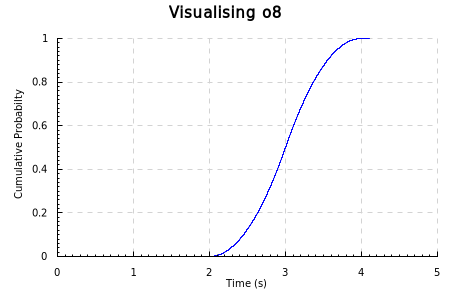

In [ ]:
toRenderable $ plotCDF "Visualising o8" o8

And you may want to add centiles to the visualisation.

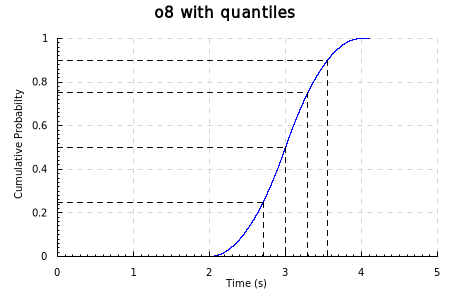

In [ ]:
toRenderable $ plotCDFWithQuantiles "o8 with quantiles"  [0.25, 0.5, 0.75, 0.9] o8

Up to this point we've been dealing with things that either definitely occur (eventaually) or never occur. 

It is at this point we step through the looking glass and incorporate the notion of a mixture of things that take time to occur along with a possibility of not occuring. 

We are going to bring together both the notion of taking time and that of 'failing' (or some other notion of non-occurance).

In [ ]:
o9 :: DQ
o9 = choice 0.75 o8 never

("bounds o9", asFloat <$> earliest o9, asFloat <$> deadline o9)
("median o9", asFloat <$> quantile o9 0.5)
("90th centile o9", asFloat <$> quantile o9 0.9)
("prob. within 3.5s", asFloat $ successWithin o9 3.5)

("bounds o9",Occurs 2.0,Occurs 4.0)

("median o9",Occurs 3.1835034)

("90th centile o9",Abandoned)

("prob. within 3.5s",0.65625)

The bounds on the values (which can occur) have not changed, but the meadian value has. There is no 90th centile any more and the probability of completing with 3.5 seconds is reduced.


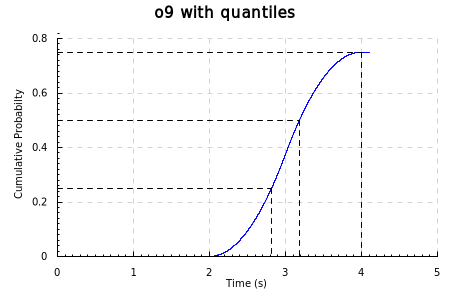

In [ ]:
toRenderable $ plotCDFWithQuantiles "o9 with quantiles"  [0.25, 0.5, 0.75, 0.9] o9

Can we create more certainty of (at least some form of) and outcome?
What if we introduce a first-to-finish with some timeout? say 5s?

("bounds o10",Occurs 2.0,Occurs 5.0)

("median o10",Occurs 3.1835034)

("90th centile o10",Occurs 5.0)

("prob. within 3.5s",0.65625)

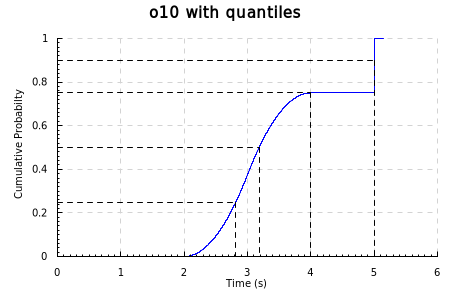

In [ ]:
o10 = o9 `firstToFinish` wait 5
("bounds o10", asFloat <$> earliest o10, asFloat <$> deadline o10)
("median o10", asFloat <$> quantile o10 0.5)
("90th centile o10", asFloat <$> quantile o10 0.9)
("prob. within 3.5s", asFloat $ successWithin o10 3.5)
toRenderable $ plotCDFWithQuantiles "o10 with quantiles"  [0.25, 0.5, 0.75, 0.9] o10

We have recovered the 'certainity', but we had to do that by inspection and insertion of specific values.
We don't have to constrain ourselves that way, as we are working in a higher order framework - we can inspect the system we are reasoning about and create suitable mitigation strategies.

Imagine we wanted to ensure that the system always made progress, even in the presence of failure. We might ensure this by encoding a rule that, if an outcome can fail then we will create a 'timeout' that occurs after the latest time.

More than this, we will create such a timeout so that it 'fires' at a specified fraction of the active duration of the outcome (the active duration being the `deadline - earliest`).

In [ ]:
ensureProgress :: DeltaQ o => Duration o -> o -> o
ensureProgress f o 
  = o `firstToFinish` timeguard (earliest o, deadline o)
  where
    timeguard (Occurs a, Occurs b)
      = wait $ b + (b - a) * f
    timeguard _ = never

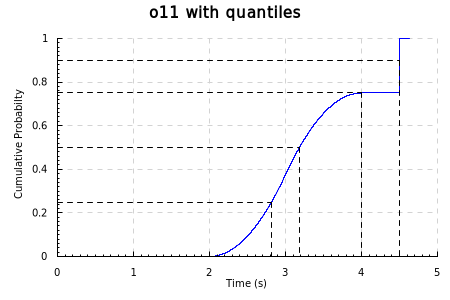

In [ ]:
o11 = ensureProgress 0.25 o9
toRenderable $ plotCDFWithQuantiles "o11 with quantiles"  [0.25, 0.5, 0.75, 0.9] o11